# Task1

In [11]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

model = MBartForConditionalGeneration.from_pretrained("SnypzZz/Llama2-13b-Language-translate")

tokenizer = MBart50TokenizerFast.from_pretrained("SnypzZz/Llama2-13b-Language-translate", src_lang="en_XX")


text = "- Translate to Korean: A large language model (LLM) is a language model notable for its ability to achieve general-purpose language generation and other natural language processing tasks such as classification."
model_inputs = tokenizer(text, return_tensors="pt")

generated_tokens = model.generate(
    **model_inputs,
    forced_bos_token_id=tokenizer.lang_code_to_id["ko_KR"]
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['대용어 모형 (대용어 모형, 대용어 모형)은 일반적인 언어 생성과 분류와 같은 자연 언어 처리를 수행할 수 있는 능력으로 유명한 언어 모형입니다.']

# Task2

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

prompt = "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English."

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

gen_tokens = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.9,
    max_length=512,
)
gen_text = tokenizer.batch_decode(gen_tokens)[0]
gen_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\nBy learning the languages of those living near the area, as well as the languages of their closest relatives, we may have already discovered what they're all like, according to the researchers. And that's pretty much it. The scientists are currently talking in a series of labs with colleagues and, of course, the media.\n\nRead more:\n\nScientists find 'lost' dinosaur, found in Bolivia\n\nThe best and worst examples of human sexuality\n\nThe biggest surprise in the world of unicorns<|endoftext|>"

# Task3

# 3-1 lambada

In [14]:
import torch
from transformers.models.opt.modeling_opt import OPTForCausalLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
import gc
from torch.nn.functional import pad
from tqdm import tqdm

class Evaluator:
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

        # tokenize the dataset
        def tokenize_function(examples):
            example = self.tokenizer(examples['text'])
            return example

        self.dataset = self.dataset.map(tokenize_function, batched=True)
        self.dataset.set_format(type='torch', columns=['input_ids'])

    @torch.no_grad()
    def evaluate(self, model):
        
        model.eval()
        total, hit = 0, 0
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        latency = 0
        for batch in tqdm(self.dataset):
            input_ids = batch['input_ids'].cuda().unsqueeze(0)
            label = input_ids[:, -1]
            pad_len = 512 - input_ids.shape[1]
            input_ids = pad(input_ids, (0, pad_len), value=1)
            torch.cuda.synchronize()
            start.record()
            outputs = model(input_ids)
            end.record()
            torch.cuda.synchronize()
            latency += start.elapsed_time(end)
            last_token_logits = outputs.logits[:, -2 - pad_len, :]
            pred = last_token_logits.argmax(dim=-1)
            total += label.size(0)
            hit += (pred == label).sum().item()

        acc = hit / total
        lantecy = latency / len(self.dataset)
        return acc, lantecy


def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024 ** 2
    print('Model size: {:.3f}MB'.format(size_all_mb))

In [15]:
from datasets import load_dataset
dataset = load_dataset('lambada', split='validation[:1000]')

models_name = ["gpt2", "gpt2-medium", "gpt2-large"]

accuracy = {}
device = "cuda"

for name in models_name:
    print(name)
    tokenizer = GPT2Tokenizer.from_pretrained(name)
    model = GPT2LMHeadModel.from_pretrained(name)
    model.to("cuda:0")
    evaluator = Evaluator(dataset, tokenizer)
    acc, lantecy_smoothquant = evaluator.evaluate(model)
    accuracy[name] = acc

gpt2


100%|██████████| 1000/1000 [00:13<00:00, 73.47it/s]


gpt2-medium


100%|██████████| 1000/1000 [00:34<00:00, 29.34it/s]


gpt2-large


100%|██████████| 1000/1000 [01:09<00:00, 14.35it/s]


In [16]:
import matplotlib.pyplot as plt

def grid_model(models, acc, title):
    plt.figure(figsize=(10,6))
    plt.bar(models, acc, color=['blue', 'green', 'red'])
    plt.xlabel("models")
    plt.title(title)
    for i, v in enumerate(models):
        plt.text(v, acc[i], acc[i],            
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',
             verticalalignment='bottom')  

    plt.show()


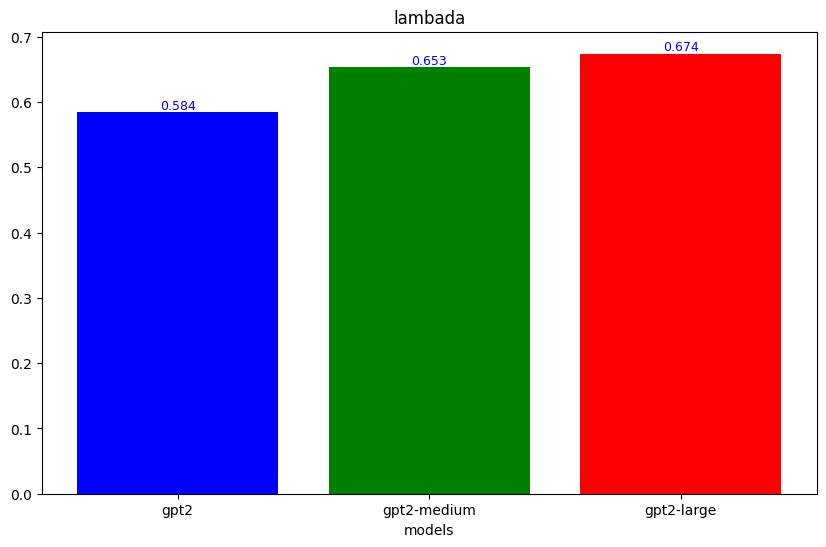

In [17]:
models = list(accuracy.keys())
acc = list(accuracy.values())
grid_model(models, acc, "lambada")

# 3 - 2

In [18]:
import torch
from tqdm import tqdm
    
def evluation(encodings):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl.item()


# print(evluation(encodings))

In [19]:
models_name = ["gpt2", "gpt2-medium", "gpt2-large"]

accuracy = {}

test = load_dataset("wikitext", "wikitext-2-v1", split="test")
for name in models_name:
    model = GPT2LMHeadModel.from_pretrained(name).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained(name)

    encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")
    accuracy[name] = evluation(encodings)

Token indices sequence length is longer than the specified maximum sequence length for this model (297300 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 579/581 [00:19<00:00, 29.77it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (297300 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 579/581 [00:49<00:00, 11.75it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (297300 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 579/581 [01:40<00:00,  5.75it/s]


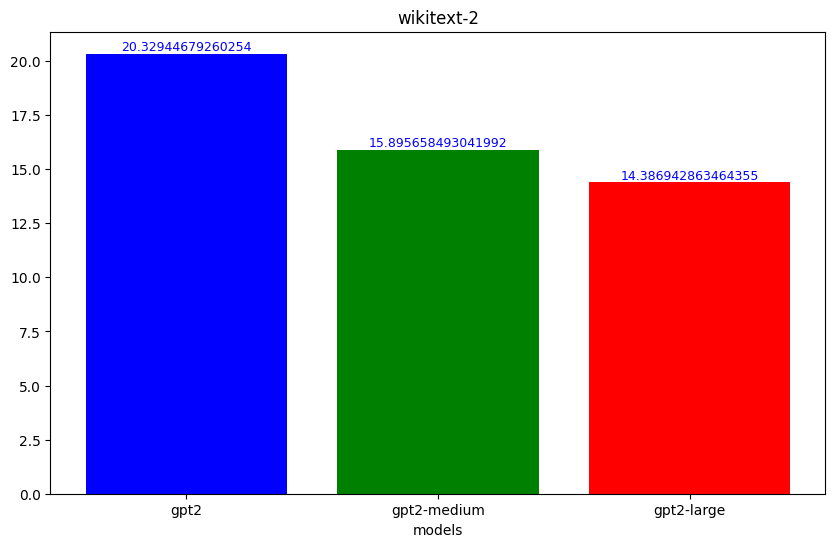

In [20]:
models = list(accuracy.keys())
acc = list(accuracy.values())
grid_model(models, acc, "wikitext-2")

# 3-3 wikitext-103

Token indices sequence length is longer than the specified maximum sequence length for this model (286657 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 558/560 [00:18<00:00, 29.72it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (286657 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 558/560 [00:47<00:00, 11.82it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (286657 > 1024). Running this sequence through the model will result in indexing errors
100%|█████████▉| 558/560 [01:36<00:00,  5.76it/s]


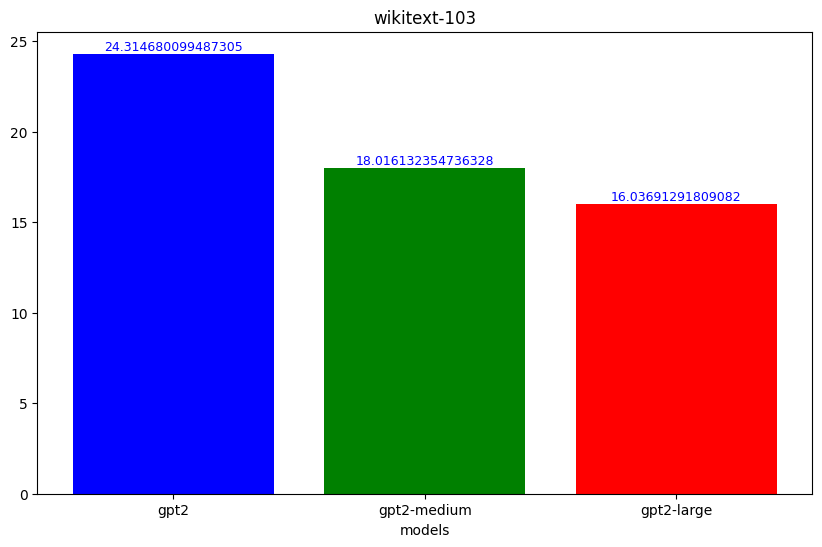

In [21]:
test = load_dataset("wikitext", "wikitext-103-v1", split="test")
for name in models_name:
    model = GPT2LMHeadModel.from_pretrained(name).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained(name)

    encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")
    accuracy[name] = evluation(encodings)
models = list(accuracy.keys())
acc = list(accuracy.values())
grid_model(models, acc, "wikitext-103")